# <center>Gold price prediction and the selection of most significant features</center>

Gold price variation can be sensitive to many features such as global economy, international tension, epidemic or global pandemic, and so on. Many efforts have been done by other scientists and researchers regarding this topic [1-7]. In this project, we are going to analysis the gold price data, and try to predict future gold prices, by exploring features which affect the price of gold more significantly.

### Data Collection, Wrangling, and Exploratory Analysis

Historical gold price data were obtained from COMEX Delayed Price Gold Feb 21 (GC=F), Currency in USD at finance.yahoo.com [8].

In [129]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from datetime import datetime, timezone, timedelta
import six
import sys
import pickle
sys.modules['sklearn.externals.six'] = six
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
mpl.rcParams['figure.dpi']=120
plt.rcParams["font.family"] = "arial"
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from yahoofinancials import YahooFinancials

We firstly downloaded the data, followed by filling the missing values of weekends and holidays with previous day's values. Then we selected closing price as dependent variable for prediction.

In [130]:
############################################
# Define a function to load data from yahoo
############################################
def get_finance(ticker, start_date='2007-12-31'):
    """Download finance data from finance.yahoo.com"""
    data0=pd.DataFrame(YahooFinancials(ticker).get_historical_price_data(start_date=start_date, 
        end_date=datetime.today().strftime('%Y-%m-%d'), 
        time_interval='daily')[ticker]['prices'])
    data0['Date']=pd.to_datetime(data0['formatted_date'])
    data1=data0.drop(columns=['date', 'formatted_date']).set_index('Date')
    return data1.resample('D').ffill()

In [131]:
gld0=get_finance('GC=F', start_date='2000-08-30')

In [132]:
# Check missing data: there is no missing data in the data set.
gld=gld0.fillna(method='ffill')
gld.head()

,high,low,open,close,volume,adjclose
Date,,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,0.0,273.899994
2000-08-31,278.299988,274.799988,274.799988,278.299988,0.0,278.299988
2000-09-01,277.000000,277.000000,277.000000,277.000000,0.0,277.000000
2000-09-02,277.000000,277.000000,277.000000,277.000000,0.0,277.000000
2000-09-03,277.000000,277.000000,277.000000,277.000000,0.0,277.000000


In [133]:
# Describe of the data set.
gld.describe()

,high,low,open,close,volume,adjclose
count,7451.000000,7451.000000,7451.000000,7451.000000,7.451000e+03,7451.000000
mean,1004.716656,994.299947,999.596752,999.620829,1.037894e+04,999.620829
std,483.911945,477.757517,480.958843,480.896541,8.483636e+04,480.896541
min,256.100006,255.000000,255.000000,255.100006,0.000000e+00,255.100006
25%,466.250000,465.000000,465.550003,466.000000,1.700000e+01,466.000000
50%,1162.300049,1150.000000,1157.199951,1157.699951,9.200000e+01,1157.699951
75%,1327.850037,1318.450012,1322.799988,1322.199951,3.555000e+02,1322.199951
max,2063.000000,2040.000000,2045.500000,2051.500000,3.271014e+06,2051.500000


Here we take Close price as dependent variable, and subset the Close column.

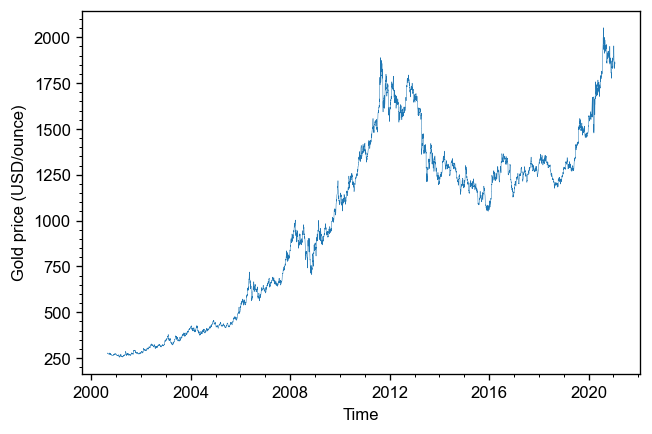

In [134]:
fig, ax=plt.subplots(1, 1)
ax.plot(gld[['close']], linewidth=0.3)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.set_xlabel('Time')
ax.set_ylabel('Gold price (USD/ounce)')
plt.show()

It is possible that other financial variables (exogenous variables) could affect gold prices. The first variable that comes to our sight is the value of US dollars, because the gold price is marked by US dollars. Other possible financial variables, including stock indices, foreign currency transaction rates, the US economy, local politics, and international tensions, etc., could also play roles on gold prices. Megan's work [4] concluded that the EUR-USD, GBP-USD, Dollar Index, S&P 500, KOSPI, and Hang Seng Index exhibit significant correlations with gold prices (the absolute correlation coefficients > 0.1). In this work, we are going to use all of these exogenous variables for the gold price prediction. In addition, we are going to add several more exogenous variables: 1) the US non-farms payroll report (NFP), which can reflect the situation of US economy, 2) the cboe volatility index (VIX), which represents the market's expectations for volatility over the coming 30 days, and can reflect the market risks caused by local politics, international tensions, among other factors, 3) crude oil prices, and 4) housing and morgage related infrastructures.

The data about EUR-USD, GBP-USD, Dollar Index, S&P 500, KOSPI, Hang Seng Index, VIX, and crude oil prices were collected from Yahoo Finance [8]. The NFP report data were collected from Federal Reserve Bank of ST. Louis [11].   

In [135]:
#########################################
# Load the exogenous variables: EUR-USD
# iPath EUR/USD Exchange Rate ETN (EROTF)
#########################################
eur_usd=get_finance('EROTF')
eur_usd.head()

,high,low,open,close,volume,adjclose
Date,,,,,,
2007-12-31,55.480000,54.900002,55.480000,55.040001,3400.0,55.040001
2008-01-01,55.480000,54.900002,55.480000,55.040001,3400.0,55.040001
2008-01-02,55.520000,53.139999,53.139999,55.490002,12800.0,55.490002
2008-01-03,55.599998,55.509998,55.549999,55.599998,1400.0,55.599998
2008-01-04,55.779999,55.630001,55.779999,55.639999,27800.0,55.639999


In [136]:
#########################################
# Load the exogenous variables: GBP-USD
# iPath GBP/USD Exchange Rate ETN (GBBEF)
#########################################
gbp_usd=get_finance('GBBEF')
gbp_usd.head()

,high,low,open,close,volume,adjclose
Date,,,,,,
2007-12-31,51.240002,51.240002,51.240002,51.240002,0,51.240002
2008-01-01,51.240002,51.240002,51.240002,51.240002,0,51.240002
2008-01-02,51.480000,47.400002,51.180000,51.380001,2600,51.380001
2008-01-03,51.270000,51.270000,51.270000,51.270000,400,51.270000
2008-01-04,51.320000,51.230000,51.320000,51.230000,200,51.230000


In [137]:
#############################################
# Load the exogenous variables: DOLLAR INDEX
# US Dollar/USDX - Index - Cash (DX-Y.NYB)
#############################################
dollar_index=get_finance('DX-Y.NYB')
dollar_index.head()

,high,low,open,close,volume,adjclose
Date,,,,,,
2007-12-31,76.750000,75.959999,75.980003,76.699997,0.0,76.699997
2008-01-01,76.750000,75.959999,75.980003,76.699997,0.0,76.699997
2008-01-02,76.650002,75.900002,76.349998,75.970001,0.0,75.970001
2008-01-03,76.160004,75.709999,75.989998,75.889999,0.0,75.889999
2008-01-04,76.080002,75.430000,75.949997,75.790001,0.0,75.790001


In [138]:
#############################################
# Load the exogenous variables: S&P 500
# S&P 500 (^GSPC)
#############################################
sp500=get_finance('^GSPC')
sp500.head()

,high,low,open,close,volume,adjclose
Date,,,,,,
2007-12-31,1475.829956,1465.130005,1475.250000,1468.359985,2440880000,1468.359985
2008-01-01,1475.829956,1465.130005,1475.250000,1468.359985,2440880000,1468.359985
2008-01-02,1471.770020,1442.069946,1467.969971,1447.160034,3452650000,1447.160034
2008-01-03,1456.800049,1443.729980,1447.550049,1447.160034,3429500000,1447.160034
2008-01-04,1444.010010,1411.189941,1444.010010,1411.630005,4166000000,1411.630005


In [139]:
#############################################
# Load the exogenous variables: KOSPI
# KOSPI Composite Index (^KS11)
#############################################
kospi=get_finance('^KS11')
kospi.head()

,high,low,open,close,volume,adjclose
Date,,,,,,
2008-01-02,1892.500000,1852.780029,1891.449951,1853.449951,246800.0,1853.449951
2008-01-03,1858.079956,1821.609985,1834.439941,1852.729980,252800.0,1852.729980
2008-01-04,1869.760010,1824.410034,1853.540039,1863.900024,298600.0,1863.900024
2008-01-05,1869.760010,1824.410034,1853.540039,1863.900024,298600.0,1863.900024
2008-01-06,1869.760010,1824.410034,1853.540039,1863.900024,298600.0,1863.900024


In [140]:
################################################
# Load the exogenous variables: Hang Seng Index
# HANG SENG INDEX (^HSI)
################################################
hangseng=get_finance('^HSI')
hangseng.head()

,high,low,open,close,volume,adjclose
Date,,,,,,
2007-12-31,27820.140625,27437.939453,27437.939453,27812.650391,8.537670e+08,27812.650391
2008-01-01,27820.140625,27437.939453,27437.939453,27812.650391,8.537670e+08,27812.650391
2008-01-02,27853.599609,27299.449219,27632.199219,27560.519531,1.232143e+09,27560.519531
2008-01-03,27223.710938,26864.130859,27050.029297,26887.279297,2.442744e+09,26887.279297
2008-01-04,27596.859375,26994.849609,27004.339844,27519.689453,2.375522e+09,27519.689453


In [141]:
################################################
# Load the exogenous variables: VIX
# CBOE Volatility Index (^VIX)
################################################
vix=get_finance('^VIX')
vix.head()

,high,low,open,close,volume,adjclose
Date,,,,,,
2007-12-31,22.750000,21.790001,21.870001,22.500000,0,22.500000
2008-01-01,22.750000,21.790001,21.870001,22.500000,0,22.500000
2008-01-02,24.049999,22.400000,22.580000,23.170000,0,23.170000
2008-01-03,23.270000,22.110001,23.110001,22.490000,0,22.490000
2008-01-04,24.299999,23.250000,23.500000,23.940001,0,23.940001


In [142]:
################################################
# Load the exogenous variables: Crude Oil
# Crude Oil Mar 21 (CL=F)
################################################
crude_oil=get_finance('CL=F')
crude_oil.head()

,high,low,open,close,volume,adjclose
Date,,,,,,
2007-12-31,96.779999,94.730003,96.120003,95.980003,108597.0,95.980003
2008-01-01,96.779999,94.730003,96.120003,95.980003,108597.0,95.980003
2008-01-02,100.000000,96.050003,96.050003,99.620003,227099.0,99.620003
2008-01-03,100.089996,98.449997,99.230003,99.180000,241269.0,99.180000
2008-01-04,99.410004,97.099998,99.169998,97.910004,231790.0,97.910004


In [143]:
################################################
# Load the exogenous variables: NFP
################################################
nfp0=pd.read_csv('..\\data\\raw\\NPPTTL_NFP.csv', parse_dates=True, index_col='DATE').resample('D').ffill()
nfp=nfp0.loc[nfp0.index>=datetime.strptime('01-01-2008', '%m-%d-%Y')]
nfp.head()

,NPPTTL
DATE,
2008-01-01,115958.337
2008-01-02,115958.337
2008-01-03,115958.337
2008-01-04,115958.337
2008-01-05,115958.337


In [144]:
#####################################################
# Join all the data together
#####################################################
whole=pd.concat([gld[['close']].loc[gld.index>=datetime.strptime('12-31-2007', '%m-%d-%Y')].rename({'close':'GLD'}, axis='columns'), 
               eur_usd[['close']].rename({'close':'EUR-USD'}, axis='columns'),
               gbp_usd[['close']].rename({'close':'GBP-USD'}, axis='columns'),
               dollar_index[['close']].rename({'close':'Dollar Index'}, axis='columns'),
               sp500[['close']].rename({'close':'S&P 500'}, axis='columns'),
               kospi[['close']].rename({'close':'KOSPI'}, axis='columns'),
               hangseng[['close']].rename({'close':'Hang Seng'}, axis='columns'),
               vix[['close']].rename({'close':'VIX'}, axis='columns'),
               crude_oil[['close']].rename({'close':'Crude Oil'}, axis='columns'),
               nfp[['NPPTTL']].rename({'NPPTTL':'NFP'}, axis='columns')
              ],
             axis='columns', join='outer').ffill()
with open('..\\data\\processed\\data.pkl', 'wb') as file:
    pickle.dump(gld, file)
    pickle.dump(eur_usd, file)
    pickle.dump(gbp_usd, file)
    pickle.dump(dollar_index, file)
    pickle.dump(sp500, file)
    pickle.dump(kospi, file)
    pickle.dump(hangseng, file)
    pickle.dump(vix, file)
    pickle.dump(crude_oil, file)
    pickle.dump(nfp, file)
    pickle.dump(whole, file)
whole.head()

,GLD,EUR-USD,GBP-USD,Dollar Index,S&P 500,KOSPI,Hang Seng,VIX,Crude Oil,NFP
Date,,,,,,,,,,
2007-12-31,834.900024,55.040001,51.240002,76.699997,1468.359985,NaN,27812.650391,22.500000,95.980003,NaN
2008-01-01,834.900024,55.040001,51.240002,76.699997,1468.359985,NaN,27812.650391,22.500000,95.980003,115958.337
2008-01-02,857.000000,55.490002,51.380001,75.970001,1447.160034,1853.449951,27560.519531,23.170000,99.620003,115958.337
2008-01-03,866.400024,55.599998,51.270000,75.889999,1447.160034,1852.729980,26887.279297,22.490000,99.180000,115958.337
2008-01-04,863.099976,55.639999,51.230000,75.790001,1411.630005,1863.900024,27519.689453,23.940001,97.910004,115958.337


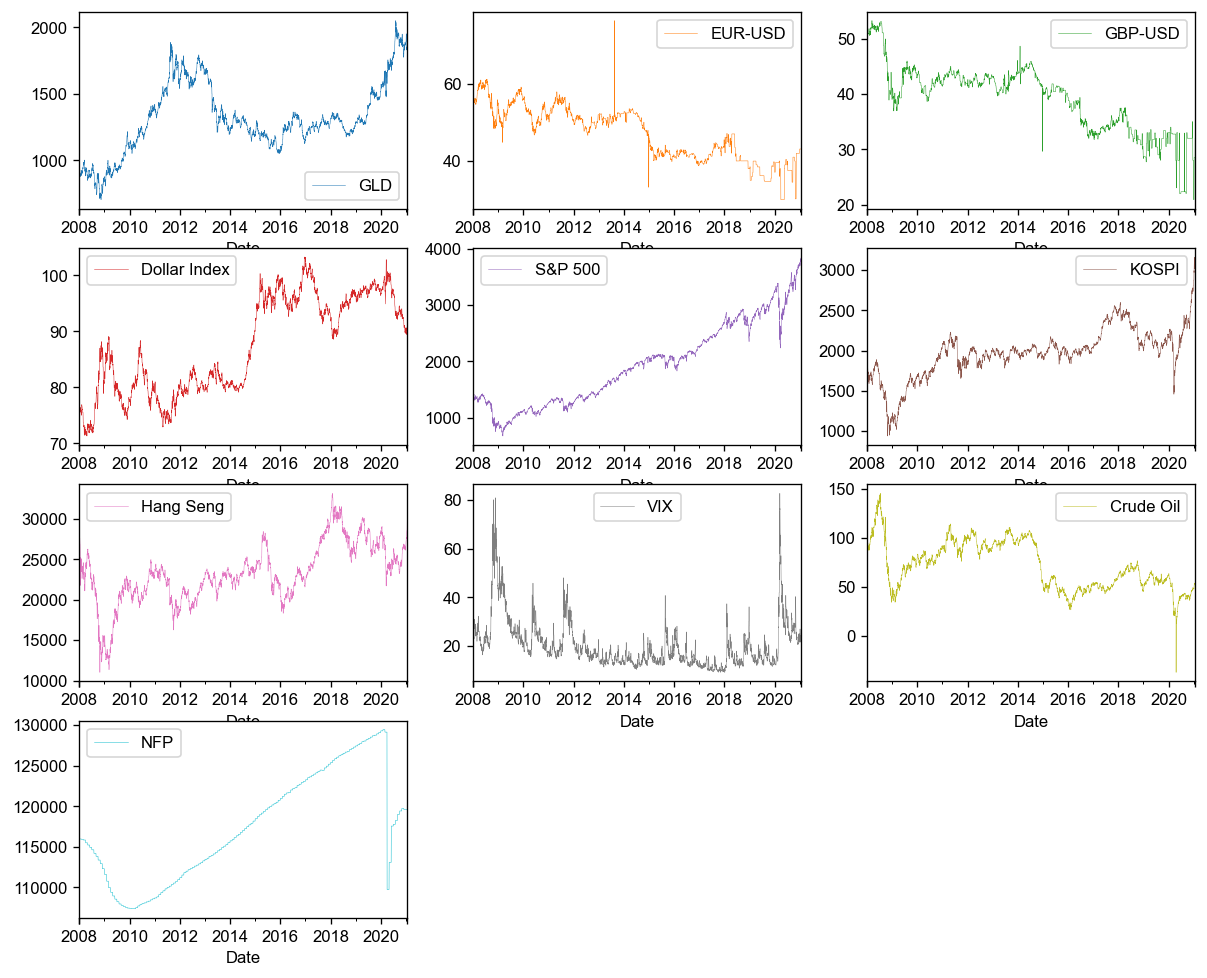

In [145]:
with open('..\\data\\processed\\data.pkl', 'rb') as file:
    gld=pickle.load(file)
    eur_usd=pickle.load(file)
    gbp_usd=pickle.load(file)
    dollar_index=pickle.load(file)
    sp500=pickle.load(file)
    kospi=pickle.load(file)
    hangseng=pickle.load(file)
    vix=pickle.load(file)
    crude_oil=pickle.load(file)
    nfp=pickle.load(file)
    whole=pickle.load(file)
fig, ax=plt.subplots(1, 1, figsize=(12, 10))
whole.plot(subplots=True, layout=(4, 3), linewidth=0.3, ax=ax)
plt.show()

### Modeling and Prediction

#### Internal Features

We would like to see if the close price is stationary, which means its probability distribution does not change over time [1]. We performed an Augmented Dicky-Fuller test on the close price. The p-value is 0.647 which is significantly larger than 0.05, indicating that the close price cannot be considered as stationary values. There are time-dependent structures in the close price values.

In [146]:
adfuller_result=adfuller(gld['close'])
print('ADF Statistic: \t{:.3f}'.format(adfuller_result[0]))
print('p-value: \t{:.3f}'.format(adfuller_result[1]))
print('Critical Values:')
for key, value in adfuller_result[4].items():
    print('\t{}: \t{:.3f}'.format(key, value))

ADF Statistic: 	-0.578
p-value: 	0.876
Critical Values:
	1%: 	-3.431
	5%: 	-2.862
	10%: 	-2.567


First, we are going to utilize a widely used statistical model for time series forecasting: AutoRegressive Integrated Moving Average (ARIMA) [9, 10], without any external features (exogenous variables). The number of autoregressive lags (p), order of differencing (d, which makes the data stationary), and number of moving average lags (q) will be optimized automatically by an auto_arima function.    

In [147]:
# Establish the auto arima model
arima_model=auto_arima(gld[['close']].loc[:datetime(2020, 1, 1)],
                      seasonal=False,
                      start_p=1,
                      start_q=1,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=52021.642, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52025.040, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=52019.642, Time=0.59 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=52019.653, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52025.414, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=52021.642, Time=0.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=52023.642, Time=1.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=52020.173, Time=0.25 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 5.382 seconds


In [148]:
# Train the arima model with the data before 2010. 
# Note that the model never sees the data after 2010 before prediction
arima_model.fit(gld[['close']].loc[:datetime(2020, 1, 1)])

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

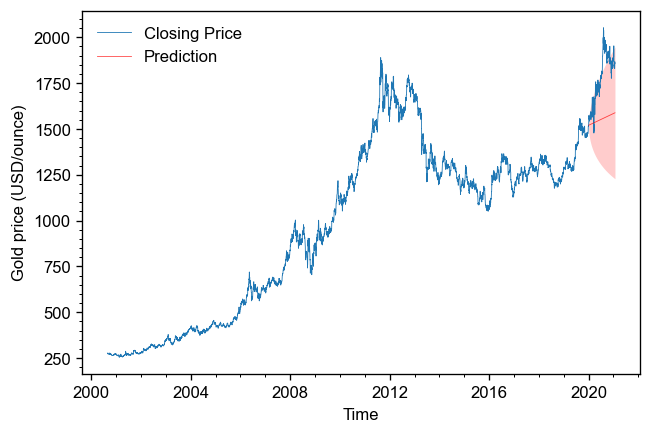

In [149]:
# Predict 2020 data
y_test, conf_int=arima_model.predict(n_periods=len(gld[['close']].loc[datetime(2020, 1, 1):].index), 
                                                  return_conf_int=True,
                                                  alpha=0.05)
prediction_2020=pd.DataFrame(y_test, 
                             index=gld[['close']].loc[datetime(2020, 1, 1):].index, 
                             columns=['Prediction'])
# Plot
fig, ax=plt.subplots(1, 1)
ax.plot(gld[['close']].index, gld['close'], 
        label='Closing Price',
       linewidth=0.5)
ax.plot(prediction_2020, label='Prediction',
       alpha=0.7, 
       linewidth=0.5, c='r')
ax.fill_between(gld[['close']].loc[datetime(2020, 1, 1):].index,
               [ele[1] for ele in conf_int],
               [ele[0] for ele in conf_int],
               alpha=0.2,
               color='r',
               linewidth=0.0)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.set_xlabel('Time')
ax.set_ylabel('Gold price (USD/ounce)')
ax.legend(frameon=False)
plt.show()


The ARIMA model performs much better than linear regression model: the predicted 2020 GLD price trend is closer to the actual data. The 95% confidence interval includes most of the actual price data. This prediction approach is close to Aihui Ong's work [1]. 

Now it's time to look into the future. We are going to re-train this model with all-time data, and predict the GLD prices in 2021 and 2022.

In [150]:
arima_model=auto_arima(gld[['close']],
                      seasonal=False,
                      start_p=1,
                      start_q=1,
                      information_criterion='aic',
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
arima_model.fit(gld[['close']])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=56104.804, Time=2.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=56107.549, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=56103.076, Time=0.61 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=56103.174, Time=1.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=56108.625, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=56104.697, Time=0.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=56106.652, Time=7.14 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=56104.338, Time=0.28 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 13.022 seconds


ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True)

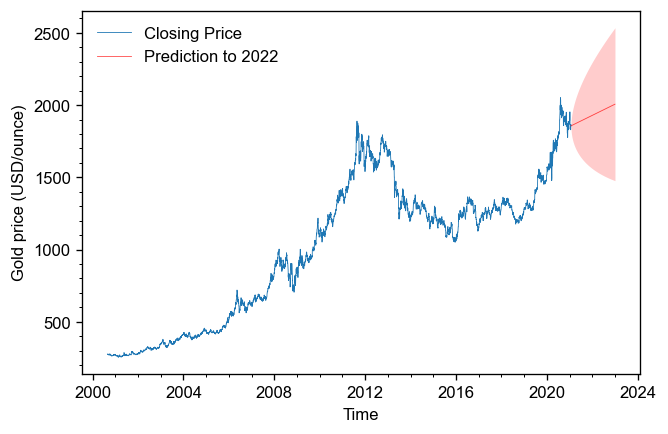

In [151]:
# From the end of the data set to the last day of 2022
how_many_days=datetime.strptime('12-31-2022', "%m-%d-%Y").date()-gld[['close']].iloc[-1].name.date()
future_time_frame=[gld[['close']].iloc[-1].name.date()+timedelta(days=i) for i in range(1, how_many_days.days+1)]
y_test, conf_int=arima_model.predict(n_periods=len(future_time_frame), 
                                                  return_conf_int=True,
                                                  alpha=0.05)
prediction_2022=pd.DataFrame(y_test, 
                             index=future_time_frame, 
                             columns=['Prediction'])
# Plot
fig, ax=plt.subplots(1, 1)
ax.plot(gld[['close']].index, gld['close'], 
        label='Closing Price',
       linewidth=0.5)
ax.plot(prediction_2022, label='Prediction to 2022',
       alpha=0.7, 
       linewidth=0.5, c='r')
ax.fill_between(future_time_frame,
               [ele[1] for ele in conf_int],
               [ele[0] for ele in conf_int],
               alpha=0.2,
               color='r',
               linewidth=0.0)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.set_xlabel('Time')
ax.set_ylabel('Gold price (USD/ounce)')
ax.legend(loc='upper left', frameon=False)
plt.show()

It seems that the gold price would still increase by the end of 2022 despite the recent drop according to the internal-feature-only prediction. So far the prediction work only used historical GLD price data, and sometimes the prediction can catch the moving momentum of price changes in a short time window. In order to improve the capacity of the model, we are going to consider exogenous variables as well. Because predicting future gold prices also needs to predict all kinds of future external features, and most of the features are hard to predict precisely. Therefore, this project is focusing on short-term prediction, such as one week, using the exogenous variables in the past. 

#### Internal and External Features

### Conclusion

### References
[1] Aihui Ong, Is Gold a Good Investment? Gold Price Prediction Using Machine Learning Techniques. https://www.springboard.com/blog/gold-price-prediction-using-machine-learning, 2020.

[2] Bhanu Yerra, Predicting Tomorrows Gold Price. Do We Have a Market Advantage? https://mlbhanuyerra.github.io/2019-10-12-Predicting-Tomorrows-Gold-Price/, 2019.

[3] ur Sami, I., and Khurum Nazir Junejo. Predicting Future Gold Rates using Machine Learning Approach. International Journal of Advanced Computer Science and Applications 8, no. 12: 92-99, 2017.

[4] Potoski, Megan. Predicting gold prices. CS229, Autumn, 2013.

[5] Ishan Shah, and Rekhit Pachanekar, Gold Price Prediction Using Machine Learning In Python. https://blog.quantinsti.com/gold-price-prediction-using-machine-learning-python/, 2020  

[6] Bingol, Sakir, Safaa Sadik, Raland Matenggo, Hatim Badr Mouhcine, Jihad Albaf, Salma Chaabene, and Aaron Auta. Gold price prediction in times of 4inancial and geopolitical uncertainty: A machine learning approach. 2020.

[7] Zhu, Han-chao, and Wang, Dong. Predict the price of gold Based on Machine Learning Techniques. DEStech Transactions on Computer Science and Engineering mmsta, 2017.

[8] https://finance.yahoo.com

[9] Box, George EP, Gwilym M. Jenkins, Gregory C. Reinsel, and Greta M. Ljung. Time series analysis: forecasting and control. John Wiley & Sons, 2015.

[10] Ariyo, Adebiyi A., Adewumi O. Adewumi, and Charles K. Ayo. "Stock price prediction using the ARIMA model." In 2014 UKSim-AMSS 16th International Conference on Computer Modelling and Simulation, pp. 106-112. IEEE, 2014.

[11] https://fred.stlouisfed.org/series/NPPTTL
